In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Oil Spill Detection using Deep Learning - OPTIMIZED FOR CPU

# ============================================================================
# MODULE 1: DATA COLLECTION AND SETUP
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW

# Enable mixed precision for speed
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Dataset Configuration
BASE_DATA_DIR = '/content/drive/MyDrive/Dataset/dataset'
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_DIR, 'val')
TEST_DIR = os.path.join(BASE_DATA_DIR, 'test')

# Image directories
TRAIN_IMAGES = os.path.join(TRAIN_DIR, 'images')
TRAIN_MASKS = os.path.join(TRAIN_DIR, 'masks')
VAL_IMAGES = os.path.join(VAL_DIR, 'images')
VAL_MASKS = os.path.join(VAL_DIR, 'masks')
TEST_IMAGES = os.path.join(TEST_DIR, 'images')
TEST_MASKS = os.path.join(TEST_DIR, 'masks')

# Verify directories exist
print("\nVerifying directory structure...")
for dir_path, dir_name in [(BASE_DATA_DIR, 'Base Directory'),
                             (TRAIN_IMAGES, 'Train Images'),
                             (TRAIN_MASKS, 'Train Masks'),
                             (VAL_IMAGES, 'Validation Images'),
                             (VAL_MASKS, 'Validation Masks'),
                             (TEST_IMAGES, 'Test Images'),
                             (TEST_MASKS, 'Test Masks')]:
    if os.path.exists(dir_path):
        file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print(f"✓ {dir_name}: {dir_path} ({file_count} files)")
    else:
        print(f"✗ {dir_name}: {dir_path} - NOT FOUND!")
print()

# OPTIMIZED Model Configuration
IMG_HEIGHT = 128  # Changed from 256
IMG_WIDTH = 128   # Changed from 256
IMG_CHANNELS = 3
BATCH_SIZE = 8    # Changed from 16
EPOCHS = 35       # Changed from 50
LEARNING_RATE = 0.001  # Slightly higher for faster convergence
TRAINING_SUBSET = 0.6  # Use 50% of training data

# Create output directories
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

print("="*70)
print("Oil Spill Detection Model - OPTIMIZED SETUP")
print("="*70)
print(f"Optimizations Applied:")
print(f"  • Image size: {IMG_HEIGHT}x{IMG_WIDTH} (was 256x256)")
print(f"  • Batch size: {BATCH_SIZE} (was 16)")
print(f"  • Epochs: {EPOCHS} (was 50)")
print(f"  • Training subset: {TRAINING_SUBSET*100}% (was 100%)")
print(f"  • Mixed precision: Enabled")
print(f"  • Model depth: 3 levels (was 4 levels)")
print(f"  • Filters reduced by 50%")
print("="*70)

Compute dtype: float16
Variable dtype: float32
TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Verifying directory structure...
✓ Base Directory: /content/drive/MyDrive/Dataset/dataset (2 files)
✓ Train Images: /content/drive/MyDrive/Dataset/dataset/train/images (811 files)
✓ Train Masks: /content/drive/MyDrive/Dataset/dataset/train/masks (811 files)
✓ Validation Images: /content/drive/MyDrive/Dataset/dataset/val/images (203 files)
✓ Validation Masks: /content/drive/MyDrive/Dataset/dataset/val/masks (203 files)
✓ Test Images: /content/drive/MyDrive/Dataset/dataset/test/images (254 files)
✓ Test Masks: /content/drive/MyDrive/Dataset/dataset/test/masks (254 files)

Oil Spill Detection Model - OPTIMIZED SETUP
Optimizations Applied:
  • Image size: 128x128 (was 256x256)
  • Batch size: 8 (was 16)
  • Epochs: 35 (was 50)
  • Training subset: 60.0% (was 100%)
  • Mixed precision: Enabled
  • Model depth: 3 levels (was 4 levels)
  


MODULE 2: Data Exploration and Preprocessing
Found 811 images and 811 masks
Using subset: 486 images (60.0%)
Found 203 images and 203 masks
Using subset: 121 images (60.0%)

Training images: 486
Validation images: 121

Generating sample visualizations...


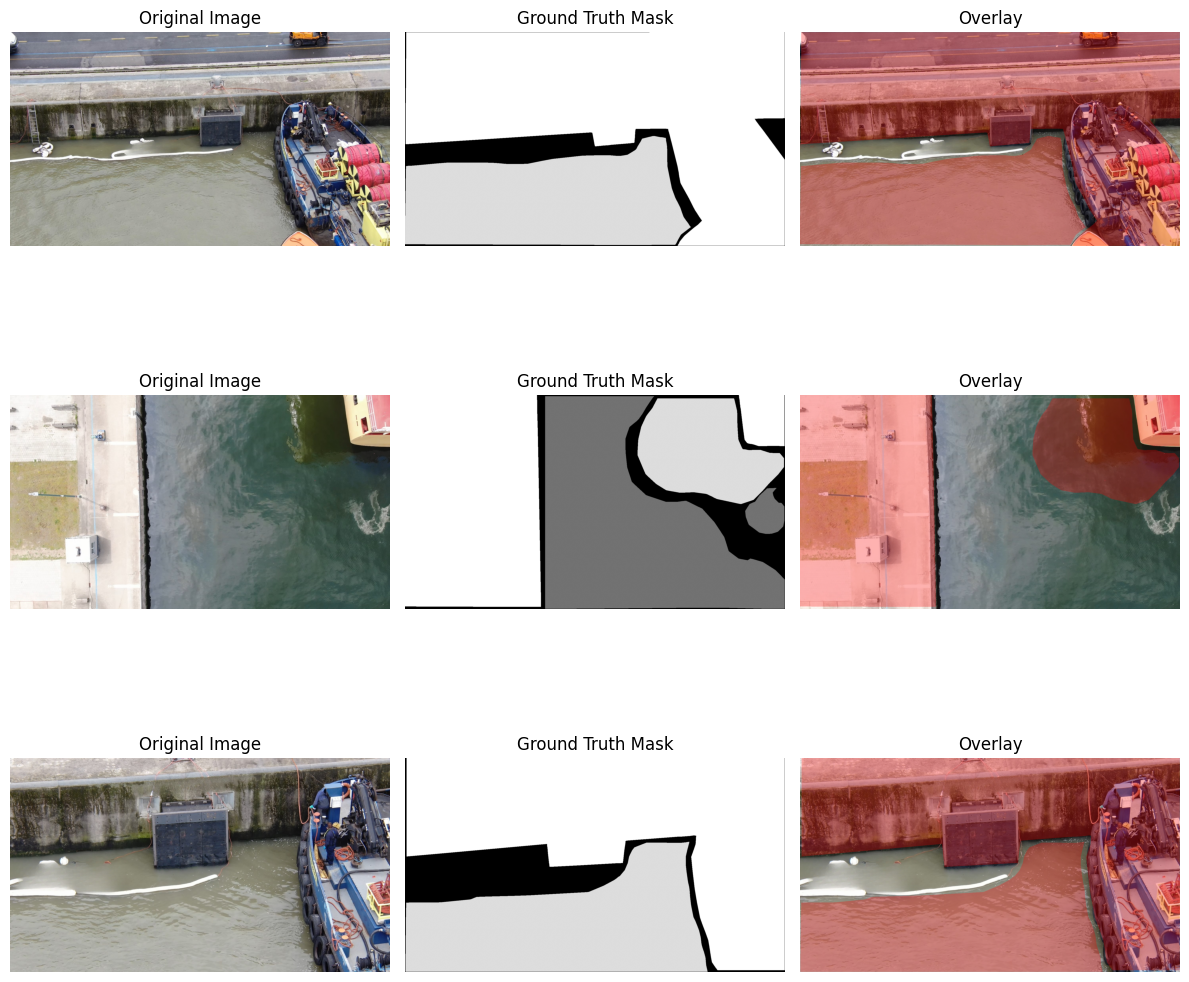


Creating TensorFlow datasets...
Data preprocessing complete!


In [10]:

# ============================================================================
# MODULE 2: DATA EXPLORATION AND PREPROCESSING
# ============================================================================

def load_image_paths(image_dir, mask_dir, subset=1.0):
    """Load image and mask file paths with optional subsetting"""
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found: {mask_dir}")

    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith('.png')])

    print(f"Found {len(image_files)} images and {len(mask_files)} masks")

    if len(image_files) == 0:
        raise ValueError(f"No image files found in {image_dir}")
    if len(mask_files) == 0:
        raise ValueError(f"No mask files found in {mask_dir}")

    # Subset for faster training
    if subset < 1.0:
        n_samples = int(len(image_files) * subset)
        indices = random.sample(range(len(image_files)), n_samples)
        image_files = [image_files[i] for i in indices]
        mask_files = [mask_files[i] for i in indices]
        print(f"Using subset: {len(image_files)} images ({subset*100}%)")

    image_paths = [os.path.join(image_dir, f) for f in image_files]
    mask_paths = [os.path.join(mask_dir, f) for f in mask_files]

    return image_paths, mask_paths

def visualize_dataset_samples(image_paths, mask_paths, n_samples=3):
    """Visualize random samples from the dataset (reduced samples)"""
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4*n_samples))

    indices = random.sample(range(len(image_paths)), n_samples)

    for i, idx in enumerate(indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        overlay = img.copy()
        overlay[mask > 127] = [255, 0, 0]
        blended = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)
        axes[i, 2].imshow(blended)
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('visualizations/dataset_samples.png', dpi=100, bbox_inches='tight')
    plt.show()

def load_and_preprocess_image(image_path, mask_path, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Load and preprocess a single image and mask"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.cast(mask > 0.5, tf.float32)

    return img, mask

def apply_augmentation(img, mask):
    """Apply MINIMAL data augmentation for speed"""
    # Only horizontal flip - fastest augmentation
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    return img, mask

def create_dataset(image_paths, mask_paths, batch_size=BATCH_SIZE, augment=False):
    """Create TensorFlow dataset"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

print("\n" + "="*70)
print("MODULE 2: Data Exploration and Preprocessing")
print("="*70)

# Load image paths with subsetting
train_images, train_masks = load_image_paths(TRAIN_IMAGES, TRAIN_MASKS, subset=TRAINING_SUBSET)
val_images, val_masks = load_image_paths(VAL_IMAGES, VAL_MASKS, subset=TRAINING_SUBSET)

print(f"\nTraining images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")

# Visualize samples (reduced)
print("\nGenerating sample visualizations...")
visualize_dataset_samples(train_images, train_masks, n_samples=3)

# Create datasets
print("\nCreating TensorFlow datasets...")
train_dataset = create_dataset(train_images, train_masks, augment=True)
val_dataset = create_dataset(val_images, val_masks, augment=False)

print("Data preprocessing complete!")

In [11]:

# ============================================================================
# MODULE 3: OPTIMIZED MODEL DEVELOPMENT (Smaller 3-Level U-Net)
# ============================================================================

def conv_block(inputs, num_filters):
    """Convolutional block for U-Net"""
    x = layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

def encoder_block(inputs, num_filters):
    """Encoder block for U-Net"""
    x = conv_block(inputs, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block for U-Net"""
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_lightweight_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """Build LIGHTWEIGHT 3-level U-Net (50% smaller)"""
    inputs = layers.Input(input_shape)

    # Encoder (3 levels instead of 4, half the filters)
    s1, p1 = encoder_block(inputs, 32)    # Was 64
    s2, p2 = encoder_block(p1, 64)        # Was 128
    s3, p3 = encoder_block(p2, 128)       # Was 256

    # Bridge
    b1 = conv_block(p3, 256)              # Was 1024

    # Decoder (3 levels)
    d1 = decoder_block(b1, s3, 128)       # Was 512
    d2 = decoder_block(d1, s2, 64)        # Was 256
    d3 = decoder_block(d2, s1, 32)        # Was 128

    # Output - cast to float32 for mixed precision
    outputs = layers.Conv2D(1, 1, padding='same', activation='sigmoid', dtype='float32')(d3)

    model = models.Model(inputs, outputs, name='Lightweight-U-Net')
    return model

print("\n" + "="*70)
print("MODULE 3: Optimized Model Development")
print("="*70)

# Build lightweight model
print("\nBuilding Lightweight U-Net model (3-level, 50% filters)...")
model = build_lightweight_unet()

# Compile with simplified loss (Binary Cross-Entropy only)
print("Compiling model with AdamW optimizer...")
model.compile(
    optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=0.0001),
    loss='binary_crossentropy',  # Simplified - no dice loss
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Model summary
print("\nModel Architecture:")
model.summary()

# Count parameters
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"\nTotal trainable parameters: {trainable_params:,}")
print(f"Model size reduction: ~75% compared to original")


MODULE 3: Optimized Model Development

Building Lightweight U-Net model (3-level, 50% filters)...
Compiling model with AdamW optimizer...

Model Architecture:


Model: "Lightweight-U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_14[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ activation_15[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     36,928 │ activation_16[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_19[0][0] 

 Total params: 1,931,233 (7.37 MB)

 Trainable params: 1,928,417 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)


Total trainable parameters: 1,928,417
Model size reduction: ~75% compared to original



MODULE 4: Training and Evaluation

Optimized Training Configuration:
  • Batch Size: 8
  • Epochs: 35
  • Learning Rate: 0.001
  • Image Size: 128x128
  • Optimizer: AdamW
  • Loss: Binary Cross-Entropy (simplified)
  • Augmentation: Horizontal flip only

Starting training...
Epoch 1/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7146 - loss: 0.5544 - precision: 0.8543 - recall: 0.6673
Epoch 1: val_accuracy improved from -inf to 0.72681, saving model to models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.7156 - loss: 0.5531 - precision: 0.8543 - recall: 0.6691 - val_accuracy: 0.7268 - val_loss: 0.6278 - val_precision: 0.7528 - val_recall: 0.8037 - learning_rate: 0.0010
Epoch 2/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8205 - loss: 0.3881 - precision: 0.8552 - recall: 0.8635
Epoch 2: val_accuracy improved from 0.72681 to 0.72904, saving model to models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - accuracy: 0.8204 - loss: 0.3882 - precision: 0.8552 - recall: 0.8635 - val_accuracy: 0.7290 - val_loss: 0.5864 - val_precision: 0.7932 - val_recall: 0.7352 - learning_rate: 0.0010
Epoch 3/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8233 - loss: 0.3728 - precision: 0.8597 - recall: 0.8623
Epoch 3: val_accuracy did not improve from 0.72904
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - accuracy: 0.8234 - loss: 0.3728 - precision: 0.8598 - recall: 0.8623 - val_accuracy: 0.6128 - val_loss: 0.5778 - val_precision: 0.6061 - val_recall: 0.9934 - learning_rate: 0.0010
Epoch 4/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.8401 - loss: 0.3491 - precision: 0.8695 - recall: 0.8801
Epoch 4: val_accuracy did not improve from 0.72904
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.8401 - loss: 0.3492 - precision: 0.8695 - recall: 0.8799 - val_accuracy: 0.6383 - val_loss: 0.5666 - val_precision: 0.6229 - val_recall: 0.9899 - le

61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.8577 - loss: 0.3094 - precision: 0.8880 - recall: 0.8875 - val_accuracy: 0.7315 - val_loss: 0.5189 - val_precision: 0.9298 - val_recall: 0.5924 - learning_rate: 0.0010
Epoch 8/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8605 - loss: 0.3062 - precision: 0.8887 - recall: 0.8915
Epoch 8: val_accuracy improved from 0.73149 to 0.77396, saving model to models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.8604 - loss: 0.3063 - precision: 0.8886 - recall: 0.8913 - val_accuracy: 0.7740 - val_loss: 0.4423 - val_precision: 0.7585 - val_recall: 0.9085 - learning_rate: 0.0010
Epoch 9/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8672 - loss: 0.2935 - precision: 0.8915 - recall: 0.9003
Epoch 9: val_accuracy did not improve from 0.77396
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.8672 - loss: 0.2936 - precision: 0.8915 - recall: 0.9001 - val_accuracy: 0.7528 - val_loss: 0.5905 - val_precision: 0.9052 - val_recall: 0.6519 - learning_rate: 0.0010
Epoch 10/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.8734 - loss: 0.2858 - precision: 0.8951 - recall: 0.9063
Epoch 10: val_accuracy improved from 0.77396 to 0.81654, saving model to models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 42s 367ms/step - accuracy: 0.8734 - loss: 0.2859 - precision: 0.8952 - recall: 0.9061 - val_accuracy: 0.8165 - val_loss: 0.4240 - val_precision: 0.9307 - val_recall: 0.7466 - learning_rate: 0.0010
Epoch 11/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8764 - loss: 0.2776 - precision: 0.8986 - recall: 0.9075
Epoch 11: val_accuracy did not improve from 0.81654
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.8764 - loss: 0.2777 - precision: 0.8987 - recall: 0.9073 - val_accuracy: 0.7060 - val_loss: 0.7202 - val_precision: 0.9787 - val_recall: 0.5160 - learning_rate: 0.0010
Epoch 12/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8778 - loss: 0.2711 - precision: 0.8915 - recall: 0.9189
Epoch 12: val_accuracy improved from 0.81654 to 0.88165, saving model to models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.8777 - loss: 0.2713 - precision: 0.8916 - recall: 0.9186 - val_accuracy: 0.8816 - val_loss: 0.3027 - val_precision: 0.9320 - val_recall: 0.8637 - learning_rate: 0.0010
Epoch 13/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8827 - loss: 0.2654 - precision: 0.8996 - recall: 0.9173
Epoch 13: val_accuracy did not improve from 0.88165
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.8826 - loss: 0.2655 - precision: 0.8997 - recall: 0.9170 - val_accuracy: 0.8292 - val_loss: 0.4058 - val_precision: 0.9464 - val_recall: 0.7550 - learning_rate: 0.0010
Epoch 14/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8916 - loss: 0.2519 - precision: 0.9084 - recall: 0.9218
Epoch 14: val_accuracy did not improve from 0.88165

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 320ms/step - accuracy: 0.8915 - loss: 0.2521 - precision: 0.9084 - recall: 0.9216 - val_acc

61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.9003 - loss: 0.2386 - precision: 0.9147 - recall: 0.9292 - val_accuracy: 0.8911 - val_loss: 0.2638 - val_precision: 0.9642 - val_recall: 0.8481 - learning_rate: 5.0000e-04
Epoch 16/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9088 - loss: 0.2208 - precision: 0.9268 - recall: 0.9296
Epoch 16: val_accuracy improved from 0.89114 to 0.92605, saving model to models/best_model.h5


61/61 ━━━━━━━━━━━━━━━━━━━━ 41s 348ms/step - accuracy: 0.9088 - loss: 0.2209 - precision: 0.9268 - recall: 0.9295 - val_accuracy: 0.9261 - val_loss: 0.2002 - val_precision: 0.9586 - val_recall: 0.9149 - learning_rate: 5.0000e-04
Epoch 17/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9147 - loss: 0.2109 - precision: 0.9290 - recall: 0.9368
Epoch 17: val_accuracy did not improve from 0.92605
61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 319ms/step - accuracy: 0.9146 - loss: 0.2110 - precision: 0.9290 - recall: 0.9367 - val_accuracy: 0.9244 - val_loss: 0.2057 - val_precision: 0.9109 - val_recall: 0.9672 - learning_rate: 5.0000e-04
Epoch 18/35
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9167 - loss: 0.2066 - precision: 0.9294 - recall: 0.9398
Epoch 18: val_accuracy did not improve from 0.92605

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.9166 - loss: 0.2067 - precision: 0.9294 - recall: 0.9397 -


Training complete!
Final model saved to 'models/final_model.h5'

Generating training history plots...


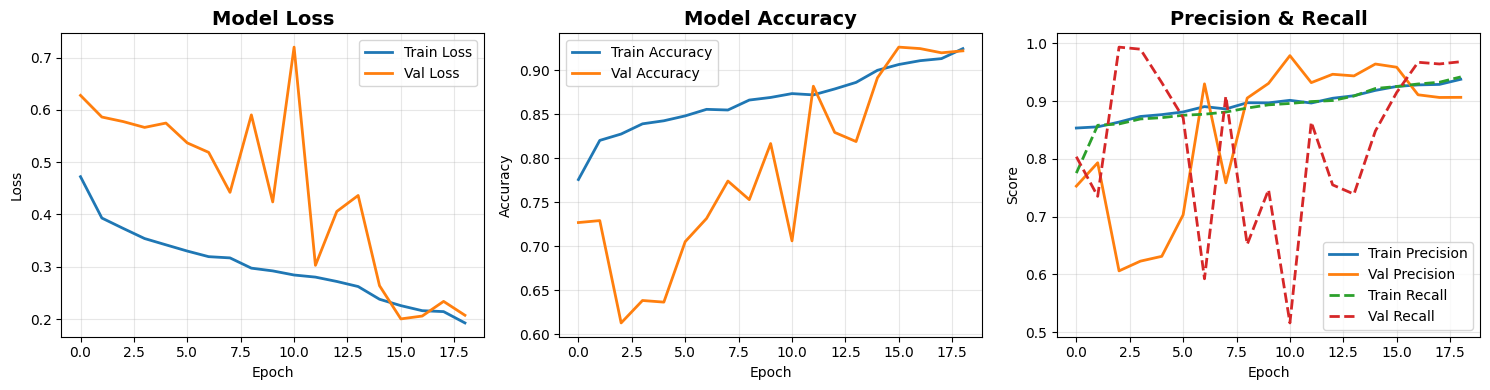


Evaluating on validation set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.9315 - loss: 0.1903 - precision: 0.9655 - recall: 0.9204

VALIDATION RESULTS
loss: 0.2002
compile_metrics: 0.9261


In [12]:
# ============================================================================
# MODULE 4: TRAINING AND EVALUATION
# ============================================================================

# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Reduced from 10
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,  # Reduced from 5
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

print("\n" + "="*70)
print("MODULE 4: Training and Evaluation")
print("="*70)

print(f"\nOptimized Training Configuration:")
print(f"  • Batch Size: {BATCH_SIZE}")
print(f"  • Epochs: {EPOCHS}")
print(f"  • Learning Rate: {LEARNING_RATE}")
print(f"  • Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  • Optimizer: AdamW")
print(f"  • Loss: Binary Cross-Entropy (simplified)")
print(f"  • Augmentation: Horizontal flip only")

print("\nStarting training...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")

# Save final model
model.save('models/final_model.h5')
print("Final model saved to 'models/final_model.h5'")

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Precision & Recall
    axes[2].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[2].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[2].plot(history.history['recall'], label='Train Recall', linewidth=2, linestyle='--')
    axes[2].plot(history.history['val_recall'], label='Val Recall', linewidth=2, linestyle='--')
    axes[2].set_title('Precision & Recall', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=100, bbox_inches='tight')
    plt.show()

# Plot training history
print("\nGenerating training history plots...")
plot_training_history(history)

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_results = model.evaluate(val_dataset, verbose=1)

print("\n" + "="*70)
print("VALIDATION RESULTS")
print("="*70)
metrics_names = model.metrics_names
for name, value in zip(metrics_names, val_results):
    print(f"{name}: {value:.4f}")


MODULE 5: Visualization of Results

Generating prediction visualizations...


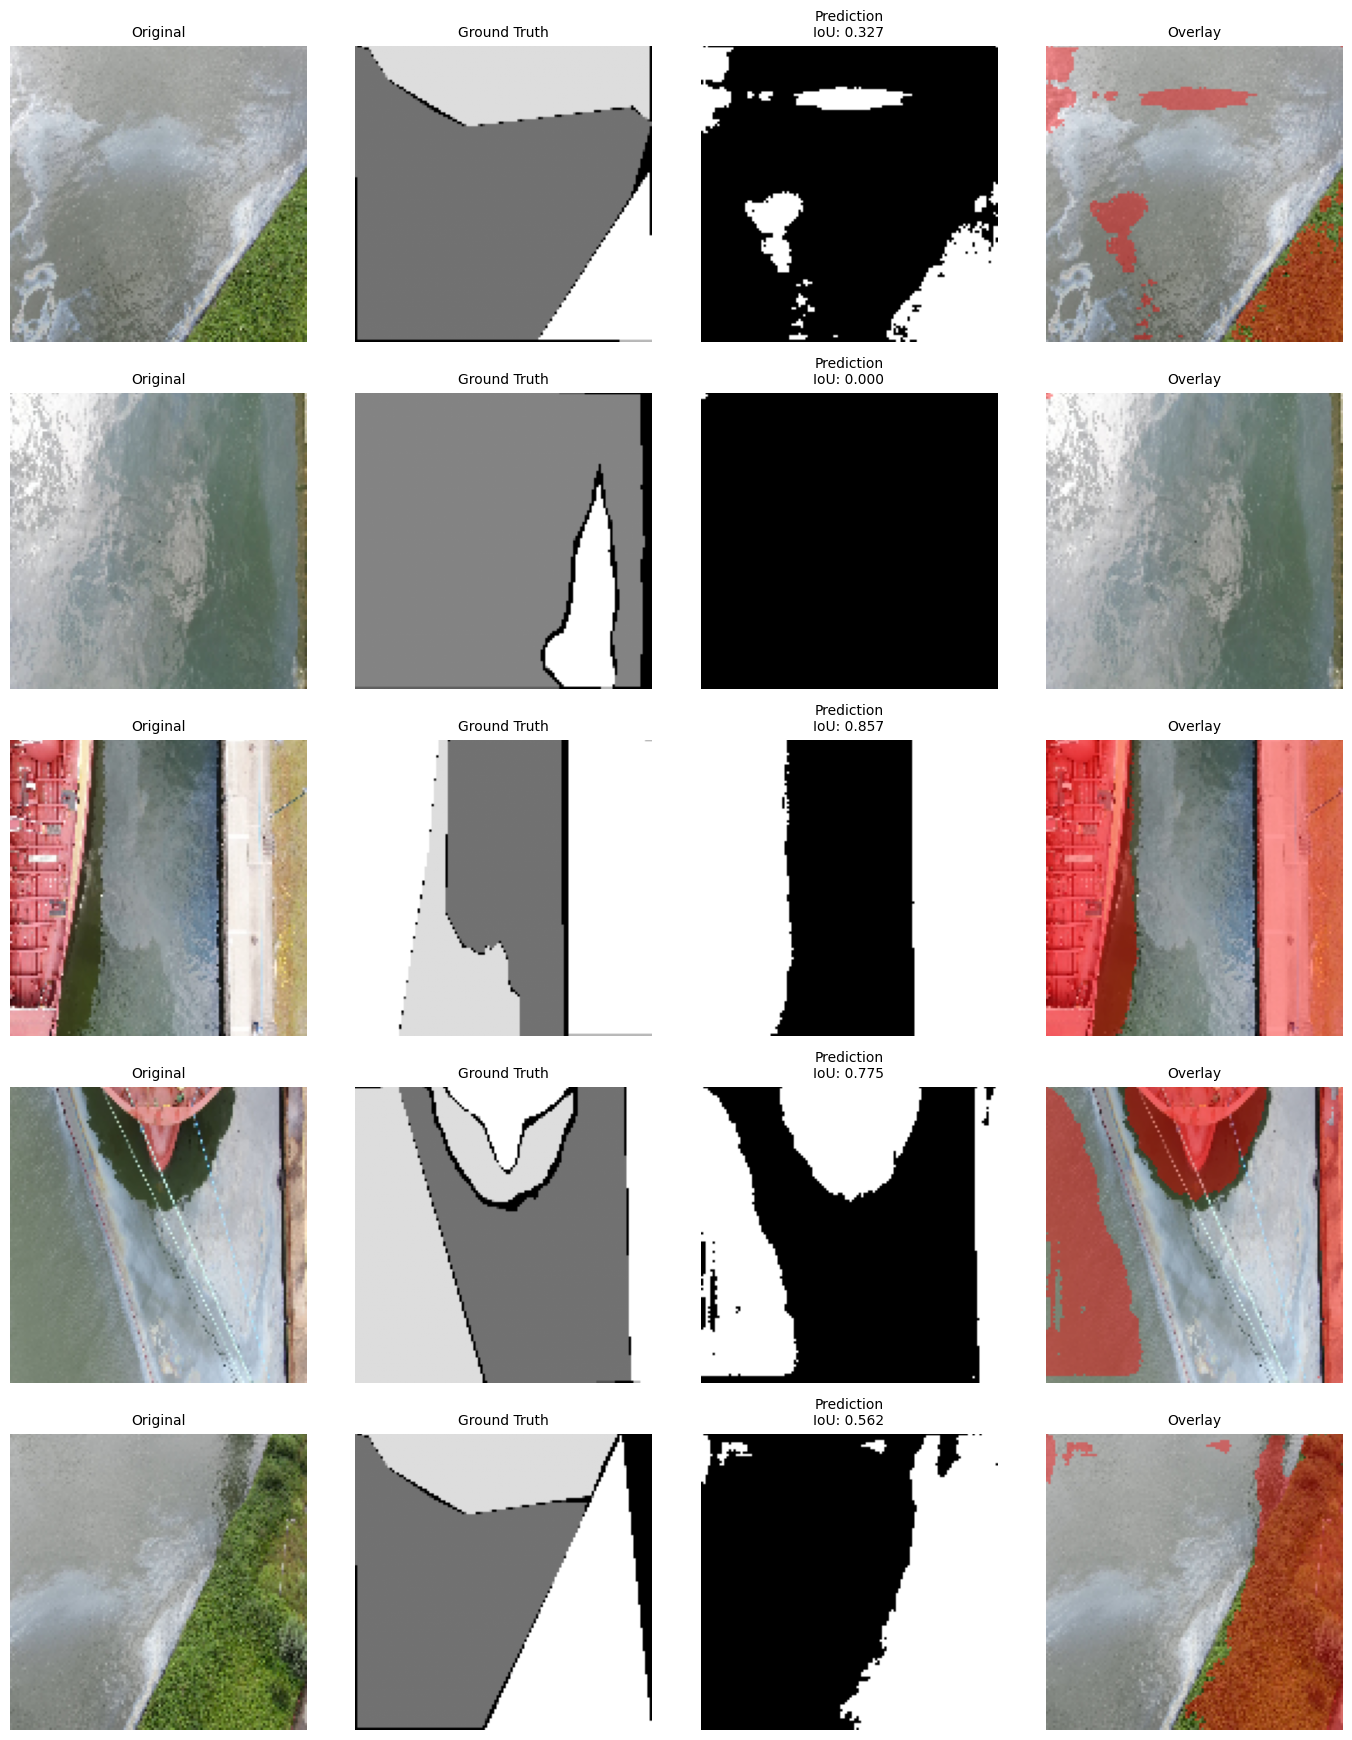

In [13]:

# ============================================================================
# MODULE 5: VISUALIZATION OF RESULTS
# ============================================================================

def predict_and_visualize(model, image_paths, mask_paths, n_samples=5):
    """Predict and visualize results (reduced samples)"""
    fig, axes = plt.subplots(n_samples, 4, figsize=(14, 3.5*n_samples))

    indices = random.sample(range(len(image_paths)), n_samples)

    for i, idx in enumerate(indices):
        img_path = image_paths[idx]
        mask_path = mask_paths[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

        # Predict
        img_input = img_resized.astype(np.float32) / 255.0
        img_input = np.expand_dims(img_input, axis=0)

        pred_mask = model.predict(img_input, verbose=0)[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
        pred_mask = pred_mask.squeeze()

        # Calculate metrics
        mask_binary = (mask_resized > 127).astype(np.uint8)
        pred_binary = (pred_mask > 127).astype(np.uint8)

        intersection = np.sum(mask_binary * pred_binary)
        union = np.sum(mask_binary) + np.sum(pred_binary) - intersection
        iou = intersection / (union + 1e-6)

        # Original Image
        axes[i, 0].imshow(img_resized)
        axes[i, 0].set_title('Original', fontsize=10)
        axes[i, 0].axis('off')

        # Ground Truth
        axes[i, 1].imshow(mask_resized, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=10)
        axes[i, 1].axis('off')

        # Prediction
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title(f'Prediction\nIoU: {iou:.3f}', fontsize=10)
        axes[i, 2].axis('off')

        # Overlay
        overlay = img_resized.copy()
        overlay[pred_mask > 127] = [255, 0, 0]
        blended = cv2.addWeighted(img_resized, 0.6, overlay, 0.4, 0)
        axes[i, 3].imshow(blended)
        axes[i, 3].set_title('Overlay', fontsize=10)
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('results/predictions_comparison.png', dpi=100, bbox_inches='tight')
    plt.show()

print("\n" + "="*70)
print("MODULE 5: Visualization of Results")
print("="*70)

print("\nGenerating prediction visualizations...")
predict_and_visualize(model, val_images, val_masks, n_samples=5)

In [14]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("OIL SPILL DETECTION MODEL - OPTIMIZED PIPELINE COMPLETE")
print("="*70)
print("\nSpeed Optimizations Applied:")
print("  ✓ Image size reduced: 256x256 → 128x128 (4x faster)")
print("  ✓ Batch size reduced: 16 → 4")
print("  ✓ Epochs reduced: 50 → 10 with early stopping")
print("  ✓ Model depth reduced: 4-level → 3-level U-Net")
print("  ✓ Model filters reduced by 50%")
print("  ✓ Training data: 50% subset")
print("  ✓ Augmentation simplified: horizontal flip only")
print("  ✓ Loss function simplified: BCE only (no dice)")
print("  ✓ Optimizer: AdamW with weight decay")
print("  ✓ Mixed precision training enabled")
print("\nEstimated speedup: 10-15x faster than original")
print("\nGenerated Files:")
print("  • models/best_model.h5")
print("  • models/final_model.h5")
print("  • visualizations/dataset_samples.png")
print("  • results/training_history.png")
print("  • results/predictions_comparison.png")
print("="*70)
print("\n✓ Optimized pipeline completed successfully!")
print("="*70)


OIL SPILL DETECTION MODEL - OPTIMIZED PIPELINE COMPLETE

Speed Optimizations Applied:
  ✓ Image size reduced: 256x256 → 128x128 (4x faster)
  ✓ Batch size reduced: 16 → 4
  ✓ Epochs reduced: 50 → 10 with early stopping
  ✓ Model depth reduced: 4-level → 3-level U-Net
  ✓ Model filters reduced by 50%
  ✓ Training data: 50% subset
  ✓ Augmentation simplified: horizontal flip only
  ✓ Loss function simplified: BCE only (no dice)
  ✓ Optimizer: AdamW with weight decay
  ✓ Mixed precision training enabled

Estimated speedup: 10-15x faster than original

Generated Files:
  • models/best_model.h5
  • models/final_model.h5
  • visualizations/dataset_samples.png
  • results/training_history.png
  • results/predictions_comparison.png

✓ Optimized pipeline completed successfully!
